In [4]:
from audiotools import AudioSignal

audio_fiile = 'airsound.wav'
asa = AudioSignal(audio_fiile).resample(44100)

print(asa.length/44100, " 초")
print(asa.audio_data.shape)
audio_data = asa.audio_data.squeeze()

device='cuda'

6.6735600907029475  초
torch.Size([1, 2, 294304])


In [5]:
# call VAE
from vae.get_function import create_autoencoder_from_config

auto_encoder_config = {
    'encoder': {
        'type': 'oobleck', # 현재는 oobleck 혹은 dac만 가능
        'requires_grad': False,
        'config': {
            'in_channels': 2,
            'channels': 128,
            'c_mults': [1, 2, 4, 8, 16],
            'strides': [2, 4, 4, 8, 8],
            'latent_dim': 128,
            'use_snake': True
        }
    },
    'decoder': {
        'type': 'oobleck',
        'requires_grad': False,
        'config': {
            'out_channels': 2,
            'channels': 128,
            'c_mults': [1, 2, 4, 8, 16],
            'strides': [2, 4, 4, 8, 8],
            'latent_dim': 64,
            'use_snake': True,
            'final_tanh': False
        }
    },
    'bottleneck': {'type': 'vae'},
    'latent_dim': 64,
    'downsampling_ratio': 2048,
    'io_channels': 2,
    'sample_rate': 44100
}

ae = create_autoencoder_from_config(auto_encoder_config)

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


latent :  torch.Size([1, 64, 143])
recon :  torch.Size([1, 2, 292864])
Reconstruction



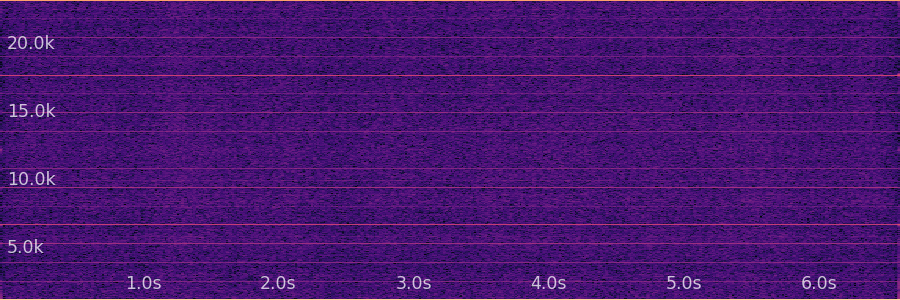
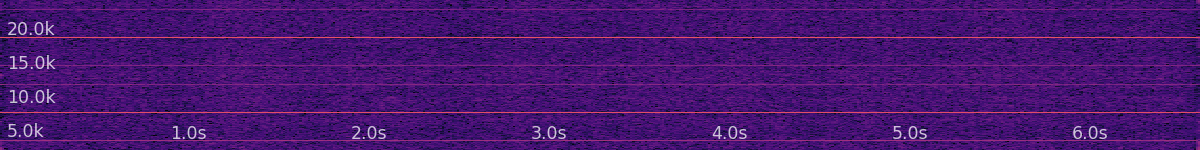

Original audio



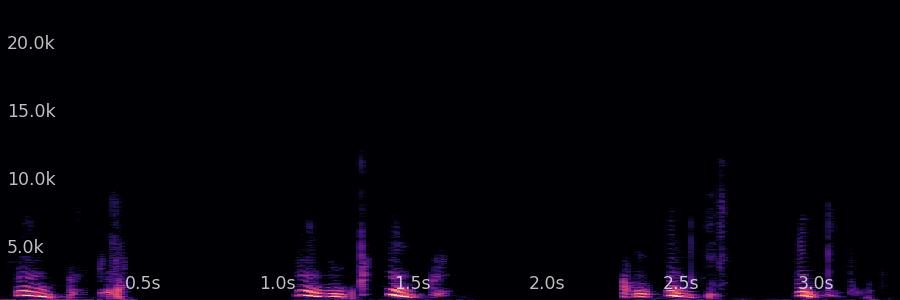
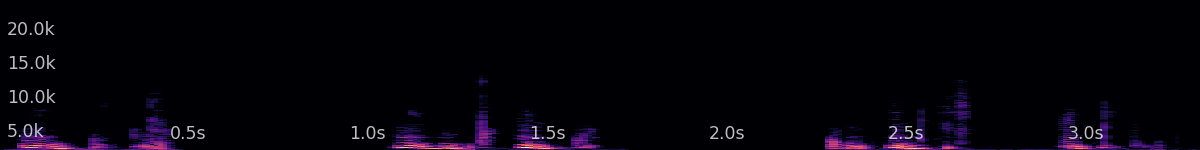

In [6]:
latent = ae.encode_audio(audio_data)
print("latent : ", latent.shape) # 21.5 Hz

audio_recon = ae.decode_audio(latent)
print("recon : ", audio_recon.shape)

print("Reconstruction")
AudioSignal(audio_recon.detach().numpy(), sample_rate=44100).widget()
print("Original audio")
asa.widget()

In [10]:
# call conditioner : text, duration seconds starts/end

from condition.conditioners import T5Conditioner
from condition.time_condition_model import NumberConditioner

text_conditioner_config = {"output_dim": 768, 't5_model_name': 't5-base', 'max_length': 128}
text_conditioner = T5Conditioner(**text_conditioner_config)

text_prompt = ['hello', 'hello']

input_ids, attention_mask = text_conditioner(text_prompt, device=device)
print(input_ids.shape, attention_mask.shape)

torch.Size([2, 128, 768]) torch.Size([2, 128])


In [11]:
duration_config = {"output_dim": 768, 'min_val': 0, 'max_val': 512}

duration_start_conditioner = NumberConditioner(**duration_config).to(device)
duration_end_conditioner = NumberConditioner(**duration_config).to(device)

seconds_start = [0, 0]
seconds_end = [5, 5]

start_emb, start_mask = duration_start_conditioner(seconds_start, device=device) # start_mask is just 1
end_emb, end_mask = duration_end_conditioner(seconds_end, device=device)

print(start_emb.shape)
print(end_emb.shape)

torch.Size([2, 1, 768])
torch.Size([2, 1, 768])


In [12]:
# noise prediction model 선언

from noise.predictmodel import ContinuousTransformer
from noise.TransformerBlock import TransformerBlock

In [13]:
d_model = 1536
num_heads = 24
dim_per_head = d_model // num_heads
cond_embed_dim = 768
input_concat_dim = 0
latent_channels = 64
dim_in = latent_channels + input_concat_dim
depth = 24 # how many transformer blocks to continue
global_cond_dim = 1536 # 각각이 768인 duration start, end 두개가 concat되어서 1536이다.

default_config = {
    'dim': d_model,
    'dim_in': dim_in,
    'dim_out': d_model,
    'depth': 24,
    'dim_heads': dim_per_head,
    'cross_attend': cond_embed_dim is not None,
    'cond_embed_dim': cond_embed_dim,
    'global_cond_dim': global_cond_dim,
    # below is default values
    'rotary_pos_emb': True,
    'zero_init_branch_outputs': True,
}

noise_predict_model = ContinuousTransformer(**default_config)

In [19]:
import torch

conditioning_tensors = {
    'prompt': (input_ids, attention_mask), # (batch, seq(max_len), channels)
    'seconds_start': (start_emb, start_mask), # (batch, seq=1, channels)
    'seconds_end': (end_emb, end_mask) # (batch, seq=1, channels)
}

# 기존 코드 : conditioning_inputs = model.get_conditioning_inputs(conditioning_tensors)
cross_attn_cond_keys = ['prompt', 'seconds_start', 'seconds_end']
global_cond_keys = ['seconds_start', 'seconds_end']

if len(cross_attn_cond_keys) > 0:
    # Concatenate all cross-attention inputs over the sequence dimension
    # Assumes that the cross-attention inputs are of shape (batch, seq, channels)
    cross_attention_inputs = []
    cross_attention_masks = []

    for key in cross_attn_cond_keys:
        cross_attn_in, cross_attn_mask = conditioning_tensors[key]
        
        cross_attention_inputs.append(cross_attn_in)
        cross_attention_masks.append(cross_attn_mask)

    cross_attention_inputs = torch.cat(cross_attention_inputs, dim=1) # dim=1 is sequence. So, total sequence length is text seq 128 + 1 + 1
    cross_attention_masks = torch.cat(cross_attention_masks, dim=1)

print("cross_attention_inputs : ", cross_attention_inputs.shape)
print("cross_attention_masks : ", cross_attention_masks.shape)


if len(global_cond_keys) > 0:
    # Concatenate all global conditioning inputs over the channel dimension
    # Assumes that the global conditioning inputs are of shape (batch, channels)
    global_conds = []
    for key in global_cond_keys:
        global_cond_input = conditioning_tensors[key][0]
        if len(global_cond_input.shape) == 3:
            global_cond_input = global_cond_input.squeeze(1)
        global_conds.append(global_cond_input)

    # Concatenate over the channel dimension 얘는 또 채널 dimension에서 하네
    global_cond = torch.cat(global_conds, dim=-1)

print("global_cond : ", global_cond.shape)

cross_attention_inputs :  torch.Size([2, 130, 768])
cross_attention_masks :  torch.Size([2, 130])
global_cond :  torch.Size([2, 1536])


In [27]:
# timestep 처리 방법
import torch.nn as nn
import math

class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn(
            [out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)

t = torch.tensor([5])
print("T : ", t.shape)

# Timestep embeddings
timestep_features_dim = 256

timestep_features = FourierFeatures(1, timestep_features_dim)
print("timestep_features : ", timestep_features(t).shape)

to_timestep_embed = nn.Sequential(
    nn.Linear(timestep_features_dim, d_model, bias=True),
    nn.SiLU(),
    nn.Linear(d_model, d_model, bias=True),
)

timestep_embed = to_timestep_embed(timestep_features(t))
print("timestep_embed : ", timestep_embed.shape)

# Timestep embedding is considered a global embedding. Add to the global conditioning if it exists
if global_cond is not None:
    global_cond = global_cond + timestep_embed
else:
    global_cond = timestep_embed

T :  torch.Size([1])
timestep_features :  torch.Size([256])
timestep_embed :  torch.Size([1536])


In [10]:
# x 는 z_t 일거고
# mask
# prepend_embeds
# prepend_mask
# global_cond
# context
# context_mask

x = latent # 1, 64, 143
context = cross_attention_inputs
context_mask = cross_attention_masks
global_cond = global_cond
prepend_embeds=None
prepend_mask=None

In [ ]:
# Add the global_embed to the prepend inputs if there is no global conditioning support in the transformer
batch_size = x.shape[0]
global_cond_type = 'prepend'

if global_cond_type == "prepend":
    # Prepend inputs are just the global embed, and the mask is all ones
    prepend_inputs = global_cond.unsqueeze(1)
    prepend_mask = torch.ones((batch_size, 1), device=x.device, dtype=torch.bool)
    prepend_length = prepend_inputs.shape[1]

extra_args = {}
if global_cond_type == "adaLN":
    extra_args["global_cond"] = global_embed